RF control
=================

In this tutorial, we demonstrate control and calibration of RF modules. The tutorial is divided into two sections:

- **[Spectroscopy measurements](#Spectroscopy-Measurements)** - in which we measure the transmission parameter (S21) of the device under test;

    * Over a large frequency range ($2.0$ - $18.0$ GHz) by sweeping the LO frequency;

    * Over a smaller frequency range ($5.0$ - $5.2$ GHz) by sweeping the NCO frequency.


- **[Mixer calibration](#Mixer-calibration)** - in which we calibrate the mixer parameters (I/Q DC offsets and IF phase/amplitude) to remove unwanted signals.


To run this tutorial, you will need:

* [QRM-RF](https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/cluster/qrm_rf.html)

* Spectrum analyzer

* Device under test: a T-connector

* Two SMA-cables

* Installation and enabling of ipywidgets:

```
        pip install ipywidgets
        jupyter nbextension enable --py widgetsnbextension
```

Setup
-----

First, we are going to import the required packages.

In [1]:

from __future__ import annotations

import json
from typing import TYPE_CHECKING, Callable

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact
from qcodes.instrument import find_or_create_instrument

from qblox_instruments import Cluster, ClusterType

if TYPE_CHECKING:
    from numpy.typing import NDArray

    from qblox_instruments.qcodes_drivers.module import QcmQrm

### Scan For Clusters

We scan for the available devices connected via ethernet using the Plug & Play functionality of the Qblox Instruments package (see [Plug & Play](https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/api_reference/tools.html#api-pnp) for more info).

In [2]:
!qblox-pnp list

Devices:
 - 10.10.200.13 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.6.2 with name "QSE_1" and serial number 00015_2321_005
 - 10.10.200.42 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.7.0 with name "QAE-I" and serial number 00015_2321_004
 - 10.10.200.43 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.6.2 with name "QAE-2" and serial number 00015_2206_003
 - 10.10.200.50 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.7.0 with name "cluster-mm" and serial number 00015_2219_003
 - 10.10.200.53 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.7.0 with name "cluster-mm" and serial number 00015_2320_004
 - 10.10.200.70 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.6.1 with name "cluster-mm" and serial number 123-456-789
 - 10.10.200.80 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.6.1 with name "cluster-mm" and serial number not_valid


In [3]:
cluster_ip = "10.10.200.42"
cluster_name = "cluster0"

### Connect to Cluster

We now make a connection with the Cluster.

In [4]:

cluster = find_or_create_instrument(
    Cluster,
    recreate=True,
    name=cluster_name,
    identifier=cluster_ip,
    dummy_cfg=(
        {
            2: ClusterType.CLUSTER_QCM,
            4: ClusterType.CLUSTER_QRM,
            6: ClusterType.CLUSTER_QCM_RF,
            8: ClusterType.CLUSTER_QRM_RF,
        }
        if cluster_ip is None
        else None
    ),
)

#### Get connected modules

In [5]:
def get_connected_modules(cluster: Cluster, filter_fn: Callable | None = None) -> dict[int, QcmQrm]:
    def checked_filter_fn(mod: ClusterType) -> bool:
        if filter_fn is not None:
            return filter_fn(mod)
        return True

    return {
        mod.slot_idx: mod for mod in cluster.modules if mod.present() and checked_filter_fn(mod)
    }

In [6]:
# QRM RF modules
modules = get_connected_modules(cluster, lambda mod: mod.is_qrm_type and mod.is_rf_type)
modules

{8: <Module: cluster0_module8 of Cluster: cluster0>}

In [7]:
readout_module = modules[8]

### Reset the Cluster

We reset the Cluster to enter a well-defined state. Note that resetting will clear all stored parameters, so resetting between experiments is usually not desirable.

In [8]:
cluster.reset()
print(cluster.get_system_status())

Status: OKAY, Flags: NONE, Slot flags: NONE


c:\work\code\qblox_instruments_install\qblox_instruments\native\generic_func.py:1033: FutureWarning: 
        After June 2024, this feature is subject to removal in future releases.
        Transition to an alternative is advised.
        See https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/getting_started/deprecated.html
        
  warnings.warn(
c:\work\code\qblox_instruments_install\qblox_instruments\native\generic_func.py:77: FutureWarning: 
            After June 2024, this feature is subject to removal in future releases.
            Transition to an alternative is advised.
            See https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/getting_started/deprecated.html
            
  self._deprecation_warning()
c:\work\code\qblox_instruments_install\qblox_instruments\native\generic_func.py:129: FutureWarning: 
            After June 2024, this feature is subject to removal in future releases.
            Transition to an alternative is advised.
       

Spectroscopy Measurements
-----------------------------------------

A common experimental step is to find the resonance frequency of a resonator. To showcase the experience flow in this case we will sweep close to the full frequency range of the QRM-RF module ($2$ - $18$ GHz) and plot the frequency response.

We start by defining a function to plot the amplitude and phase of the output signal.

In [9]:
def plot_spectrum(freq_sweep_range: NDArray, I_data: NDArray, Q_data: NDArray) -> None:
    amplitude = np.sqrt(I_data**2 + Q_data**2)
    phase = np.arctan2(Q_data, I_data) * 180 / np.pi

    plt.rcParams["axes.labelsize"] = 18
    plt.rcParams["xtick.labelsize"] = 16
    plt.rcParams["ytick.labelsize"] = 16

    fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True, figsize=(15, 7))

    ax1.plot(freq_sweep_range / 1e9, amplitude, color="#00839F", linewidth=2)
    ax1.set_ylabel("Amplitude (V)")

    ax2.plot(freq_sweep_range / 1e9, phase, color="#00839F", linewidth=2)
    ax2.set_ylabel(r"Phase ($\circ$)")
    ax2.set_xlabel("Frequency (GHz)")
    fig.tight_layout()
    plt.show()

### Setup
Connect the output of QRM-RF to its input via a T-connector (one end of the T-connector should be left open so as to produce a resonator) as shown in the figure below.

**Note**: this will not work if a splitter is used.

![Diagram.png](RF_Tutorial_Diagram.png)

Initially, we need to define the waveforms and acquisition memory. As we are using the NCO to generate an IF signal, we can use a constant (DC) waveform. We need to make sure that the waveform is long enough to run during the whole acquisition integration length and to compensate for the delay of output to input (the `holdoff_length`). Finally, we will also add averaging to increase the signal-to-noise ratio (SNR) of the measurements.

In [10]:
# Parameters
no_averages = 10
integration_length = 1024
holdoff_length = 200
waveform_length = integration_length + holdoff_length

For simplicity, a single bin is used in this tutorial.

In [11]:
# Acquisitions
acquisitions = {"acq": {"num_bins": 1, "index": 0}}

Now that the waveform and acquisition have been specified for the sequence, we need a Q1ASM program that sequences the waveforms and triggers the acquisitions. This program plays a DC wave, waits for the specified hold-off time and then acquires the signal. This process is repeated for the specified number of averages, with the average being done within the hardware.

In [12]:
seq_prog = f"""
      move    {no_averages},R0           # Average iterator.
      nop
      reset_ph
      set_awg_offs 10000, 10000          # set amplitude of signal
      nop
loop:
      wait     {holdoff_length}          # Wait time of flight
      acquire  0,0,{integration_length}  # Acquire data and store them in bin_n0 of acq_index.
      loop     R0,@loop                  # Run until number of average iterations is done.
      stop                               # Stop the sequencer
      """

# Add sequence to single dictionary and write to JSON file.
sequence = {
    "waveforms": {},
    "weights": {},
    "acquisitions": acquisitions,
    "program": seq_prog,
}
with open("sequence.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)
    file.close()

# Upload sequence
readout_module.sequencer0.sequence("sequence.json")

The device and sequencer can now be configured. In the RF modules, there is a switch directly before the output connector, which needs to be turned on to get a signal out of the device. The switch is controlled through the marker interface, first we must enable to override of the marker, then we must set the appropriate bits to enable the signal at the output.

Additionally, we set the output paths DC offset to known values. We look into the details of this parameter further on in this tutorial. Additionally, we configure the sequencer, the acquisition and set the NCO frequency. More information on these configurations can be found in the [Basic Sequencing](https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/tutorials/q1asm_tutorials/basic/rf/basic_sequencing.html), [Scope Acquisition](https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/tutorials/q1asm_tutorials/basic/rf/scope_acquisition.html) and [NCO](https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/tutorials/q1asm_tutorials/basic/baseband/nco_control.html) tutorials, respectively.

In [13]:
readout_module.disconnect_outputs()
readout_module.disconnect_inputs()

# Configure channel map
readout_module.sequencer0.connect_sequencer("io0")

readout_module.sequencer0.marker_ovr_en(True)
readout_module.sequencer0.marker_ovr_value(3)  # Enables output on QRM-RF

# Set offset in mV
readout_module.out0_offset_path0(5.5)
readout_module.out0_offset_path1(5.5)

# Configure scope mode
readout_module.scope_acq_sequencer_select(0)
readout_module.scope_acq_trigger_mode_path0("sequencer")
readout_module.scope_acq_trigger_mode_path1("sequencer")

# Configure the sequencer
readout_module.sequencer0.mod_en_awg(True)
readout_module.sequencer0.demod_en_acq(True)
readout_module.sequencer0.nco_freq(100e6)
readout_module.sequencer0.integration_length_acq(integration_length)
readout_module.sequencer0.sync_en(True)

# NCO delay compensation
readout_module.sequencer0.nco_prop_delay_comp_en(True)

Now we are ready to start the spectroscopy measurements.

In [14]:
lo_sweep_range = np.linspace(2e9, 18e9, 161)

lo_data_0 = []
lo_data_1 = []

for lo_val in lo_sweep_range:
    # Update the LO frequency.
    readout_module.out0_in0_lo_freq(lo_val)

    # Clear acquisitions
    readout_module.sequencer0.delete_acquisition_data("acq")

    readout_module.arm_sequencer(0)
    readout_module.start_sequencer()

    # Wait for the sequencer to stop with a timeout period of one minute.
    readout_module.get_acquisition_status(0, timeout=1)

    # Move acquisition data from temporary memory to acquisition list.
    readout_module.store_scope_acquisition(0, "acq")

    # Get acquisition list from instrument.
    data = readout_module.get_acquisitions(0)["acq"]

    # Store the acquisition data.
    lo_data_0.append(data["acquisition"]["bins"]["integration"]["path0"][0])
    lo_data_1.append(data["acquisition"]["bins"]["integration"]["path1"][0])

c:\work\code\qblox_instruments_install\qblox_instruments\native\generic_func.py:3210: FutureWarning: 
        After June 2024, this feature is subject to removal in future releases.
        Transition to an alternative is advised.
        See https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/getting_started/deprecated.html
        
  warnings.warn(
c:\work\code\qblox_instruments_install\qblox_instruments\native\generic_func.py:2414: FutureWarning: 
        After June 2024, this feature is subject to removal in future releases.
        Transition to an alternative is advised.
        See https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/getting_started/deprecated.html
        
  warnings.warn(
c:\work\code\qblox_instruments_install\qblox_instruments\native\generic_func.py:85: FutureWarning: 
            After June 2024, this feature is subject to removal in future releases.
            Transition to an alternative is advised.
            See https://qblox-qblox

We plot the acquired signal's amplitude and phase.

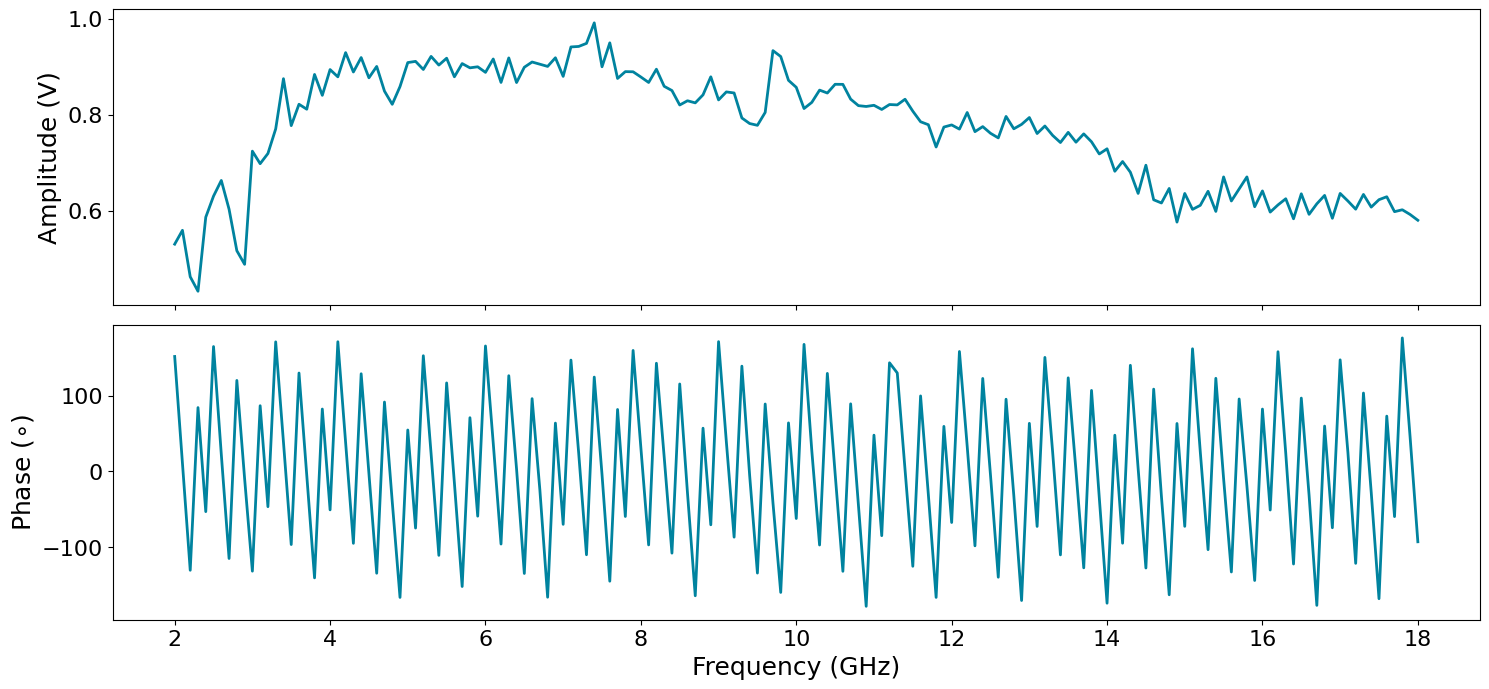

In [15]:
# The result still needs to be divided by the integration length to make sure
# the units are correct.
lo_data_0 = np.asarray(lo_data_0) / integration_length
lo_data_1 = np.asarray(lo_data_1) / integration_length

# Plot amplitude/phase results
plot_spectrum(lo_sweep_range, lo_data_0, lo_data_1)

From the spectroscopy measurements, we can see that the resonance dip of the resonator is at roughly $6.5$ GHz.

### Frequency sweep using NCO

Instead of sweeping the LO frequency, we can instead sweep the NCO. More information on the NCO can be found in the [NCO Control Tutorial](https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/tutorials/q1asm_tutorials/basic/baseband/nco_control.html). We perform a frequency sweep from $5.0$ to $5.2$ GHz by setting the LO frequency to $4.95$ GHz, such that the NCO frequency is swept from $50$ to $250$ MHz. Due to possible LO leakage we avoid NCO frequencies below $\pm10$ MHz. Additionally, due to the analog filters, which cause a decrease in the output signal as the frequency increases, see [NCO Control Tutorial](https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/tutorials/q1asm_tutorials/basic/baseband/nco_control.html), we choose to remain below $250$ MHz.

In [16]:
freq_sweep_range = np.linspace(5.0e9, 5.2e9, 200)

# LO settings
lo_freq = 4.95e9
readout_module.out0_in0_lo_freq(lo_freq)

# NCO delay compensation
readout_module.sequencer0.nco_prop_delay_comp_en(True)

We run the frequency sweep. This is simply a loop where we set the frequency by updating the QCoDeS NCO frequency parameter and then run the Q1ASM program defined in the previous example. We measure the run time using the `%%time` IPython magic command.

In [17]:
%%time
data_0 = []
data_1 = []

for freq_val in freq_sweep_range:
    # Update the NCO frequency.
    readout_module.sequencer0.nco_freq(freq_val - lo_freq)

    # Clear acquisitions
    readout_module.sequencer0.delete_acquisition_data("acq")

    readout_module.arm_sequencer(0)
    readout_module.start_sequencer()

    # Wait for the sequencer to stop with a timeout period of one minute.
    readout_module.get_acquisition_status(0, timeout=1)

    # Move acquisition data from temporary memory to acquisition list.
    readout_module.store_scope_acquisition(0, "acq")

    # Get acquisition list from instrument.
    data = readout_module.get_acquisitions(0)["acq"]

    # Store the acquisition data.
    data_0.append(data["acquisition"]["bins"]["integration"]["path0"][0])
    data_1.append(data["acquisition"]["bins"]["integration"]["path1"][0])

CPU times: total: 219 ms
Wall time: 13.8 s


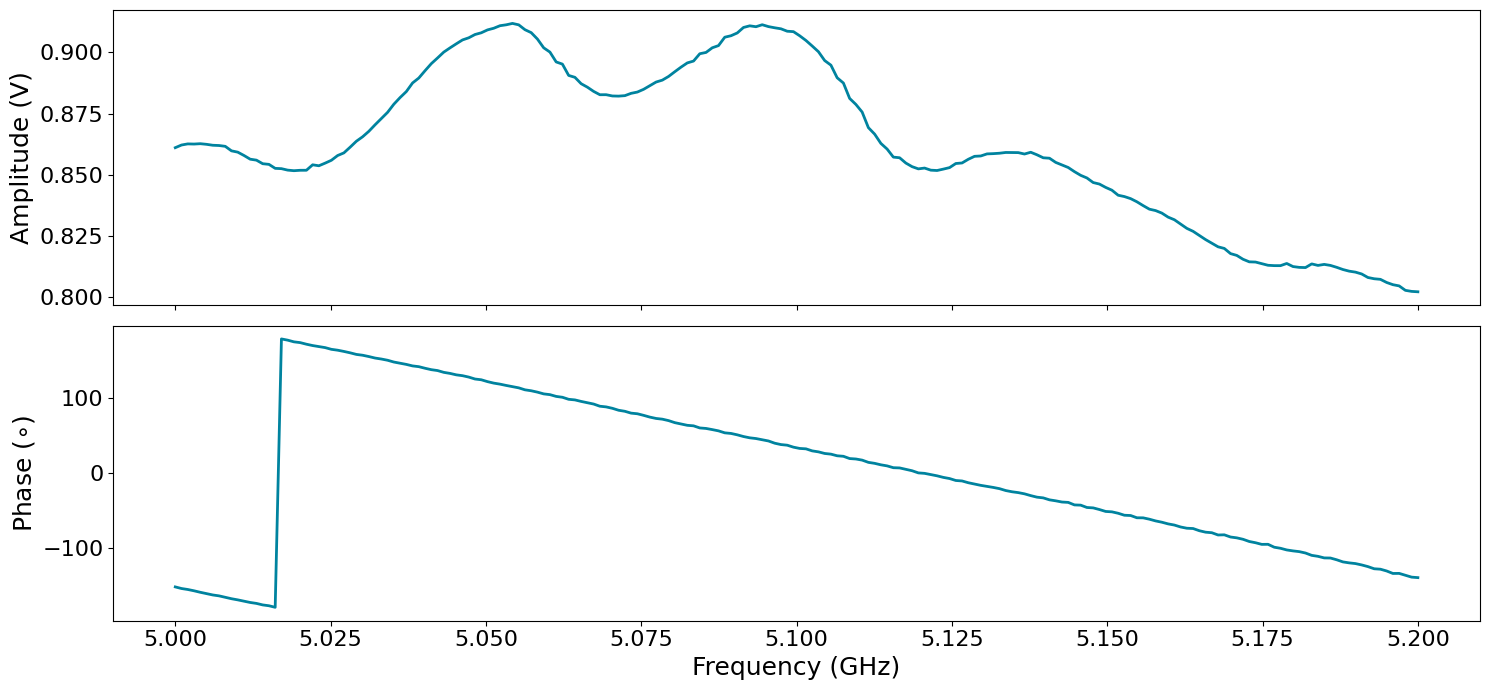

In [18]:
# The result still needs to be divided by the integration length to make sure
# the units are correct.
data_0 = np.asarray(data_0) / integration_length
data_1 = np.asarray(data_1) / integration_length

# Plot amplitude/phase results
plot_spectrum(freq_sweep_range, data_0, data_1)

### Fast frequency sweep

The same spectroscopy measurement can be done by sweeping the NCO frequency directly in the Q1ASM sequence, with a considerable time speed-up in comparison with updating the QCoDes parameters.

The Q1ASM sequencer program only supports integer values. However, the NCO has a frequency resolution of 0.25 Hz. As such, the frequency values in the sequencer program must be given as integer multiples of $1/4$ Hz.

In [19]:
freq_sweep_range = np.linspace(5.0e9, 5.2e9, 200)

lo_freq = 4.95e9
readout_module.out0_in0_lo_freq(lo_freq)

start_freq = np.min(freq_sweep_range) - lo_freq
stop_freq = np.max(freq_sweep_range) - lo_freq
n_steps = len(freq_sweep_range)
step_freq = (stop_freq - start_freq) / n_steps

# NCO frequency range settings
nco_int_start_freq = int(4 * start_freq)
nco_int_step_freq = int(4 * step_freq)

We set up the QRM-RF for continuous wave output, similarly to what was done in the previous example, and binned acquisition with multiple bins - equal to the number of frequency steps. The maximum number of points that can be measured using this method is $131072$ per sequencer, which corresponds to the maximum number of bins.

In [20]:
# Acquisitions
acquisitions = {"multi": {"num_bins": n_steps, "index": 0}}

The Q1ASM sequence program is defined with two loops, one for the averaging and a second one for the frequency sweep, i.e. the measurement itself.

In [21]:
# Program sequence
program = f"""
        move            {no_averages}, R0                   # Include number of averages
avg:
        move            {nco_int_start_freq}, R1            # Start frequency
        move            0, R2                               # Step counter
        reset_ph                                         # Reset phase of signal
        set_awg_offs    10000, 10000                        # Set amplitude of signal
nco_f:
        set_freq        R1                               # Set the frequency
        add             R1, {nco_int_step_freq}, R1      # Update the frequency register
        upd_param       200                              # Update settings and wait for time of flight
        acquire         0, R2, {integration_length}      # Acquire data and store them in bin_n0 of acq_index.
        add             R2, 1, R2                        # Update the step register
        nop
        jlt             R2, {n_steps}, @nco_f            # Loop over all frequencies
        loop            R0, @avg
        stop                                             # Stop
"""

# Upload sequence
readout_module.sequencer0.sequence(
    {
        "waveforms": {},
        "weights": {},
        "acquisitions": acquisitions,
        "program": program,
    }
)

We perform the spectroscopy measurement using `%%time` magic command again, so that we can compare the run time of both measurement methods.

In [22]:
%%time
readout_module.delete_acquisition_data(0, "multi")
readout_module.arm_sequencer(0)
readout_module.start_sequencer()
readout_module.get_acquisition_status(0, timeout=1)
readout_module.store_scope_acquisition(0, "multi")
data = readout_module.get_acquisitions(0)["multi"]

CPU times: total: 0 ns
Wall time: 68.8 ms


Comparing the run time of performing the same spectroscopy measurement by updating the QCoDes parameters and by sweeping the frequency within the Q1ASM sequence program, we see that the latter is two orders of magnitude faster. We now plot the results, to verify that they are equal to those measured in the first example.

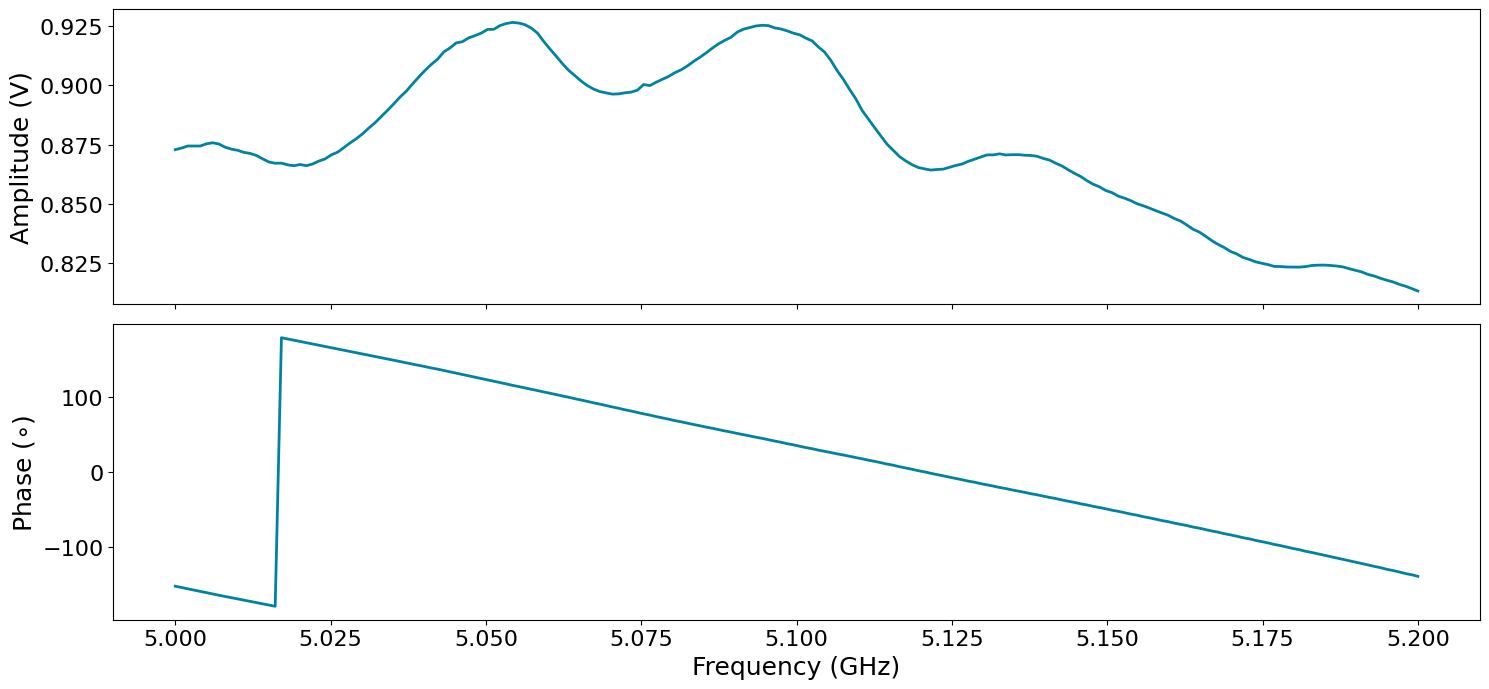

In [23]:
data_0 = np.asarray(data["acquisition"]["bins"]["integration"]["path0"]) / integration_length
data_1 = np.asarray(data["acquisition"]["bins"]["integration"]["path1"]) / integration_length

# Plot amplitude/phase results
plot_spectrum(freq_sweep_range, data_0, data_1)

### Signal Attenuation

The QRM-RF module provides the possibility of attenuating both the output and input signals. The attenuation values can be set within the range from $0$ to $60$ dB, in $2$ dB steps.

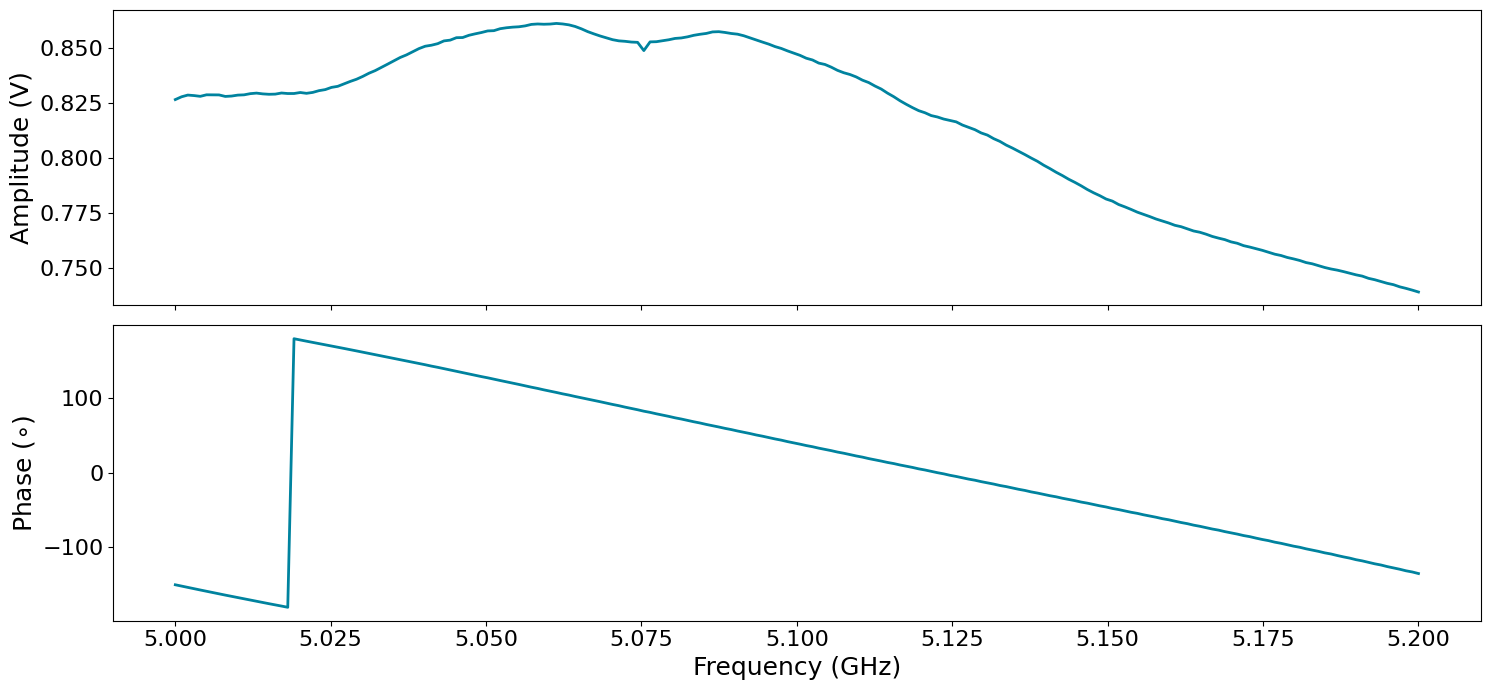

In [24]:
# Output Attenuation (dB)
readout_module.out0_att(4)

# Input Attenuation (dB)
readout_module.in0_att(0)

# Fast NCO frequency sweep
readout_module.delete_acquisition_data(0, "multi")
readout_module.arm_sequencer(0)
readout_module.start_sequencer()
readout_module.get_acquisition_status(0, timeout=1)
data = readout_module.get_acquisitions(0)["multi"]

data_0 = np.asarray(data["acquisition"]["bins"]["integration"]["path0"]) / integration_length
data_1 = np.asarray(data["acquisition"]["bins"]["integration"]["path1"]) / integration_length

# Plot amplitude/phase results
plot_spectrum(freq_sweep_range, data_0, data_1)

Mixer calibration
------------------------
For this section, we are going to look at the output spectrum of the QRM at a fixed output frequency of 5 GHz, by connecting $\text{O}^{1}$ to the spectrum analyzer. We start by resetting the device to make sure it's in a well-defined state. Note that resetting will clear all stored parameters, so resetting between experiments is usually not desirable.
We then upload a simple sequence program that keeps playing the DC waveform. This will be modulated and upconverted within the QRM-RF before outputting.

In [25]:
cluster.reset()
print(cluster.get_system_status())

# Sequence program.
seq_prog = """
      wait_sync 4

loop: play    0,0,1200
      jmp     @loop
"""
waveforms = {"dc": {"data": [0.5 for i in range(0, 1200)], "index": 0}}

# Add sequence to single dictionary and write to JSON file.
sequence = {
    "waveforms": waveforms,
    "weights": {},
    "acquisitions": acquisitions,
    "program": seq_prog,
}
with open("sequence.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)
    file.close()

readout_module.sequencer0.sequence("sequence.json")

Status: OKAY, Flags: NONE, Slot flags: NONE


Let's configure the sequencer to generate an IF frequency of $100$ MHz. To get an output frequency of $5.0$ GHz, we then have to configure the LO to run at $4.9$ GHz.

In [26]:
# Configure the Local oscillator
if readout_module.is_qrm_type:
    readout_module.out0_in0_lo_freq(5e9 - 100e6)
else:
    readout_module.out0_lo_freq(5e9 - 100e6)

readout_module.sequencer0.marker_ovr_en(True)
readout_module.sequencer0.marker_ovr_value(3)  # Enables output on QRM-RF

# Configure the sequencer
readout_module.sequencer0.mod_en_awg(True)
readout_module.sequencer0.nco_freq(100e6)
readout_module.sequencer0.sync_en(True)

readout_module.arm_sequencer(0)
readout_module.start_sequencer(0)

print(readout_module.get_sequencer_status(0))

Status: RUNNING, Flags: NONE


Connect the output of the QRM-RF (O1) to the spectrum analyzer. This is what the output looks like on the spectrum analyzer (center frequency at 4.85 GHz with 600 MHz bandwidth).

![IQ_Mixer_Calib_before.png](IQ_Mixer_Calib_before.png)

As we can see from this image, the output is not exactly the single peak at 5 GHz that we want. We seem to have some LO leakage (at 4.9 GHz) and an unwanted sideband (4.8 GHz). This is due to mixer imperfections. We can suppress these by calibrating the mixer:

* Using DC offsets we can lower the LO leakage.
* By changing the gain ratio and phase of the IF signal we can cancel the unwanted sideband.

Create control sliders for theses parameters. Each time the value of a parameter is updated, the sequencer is automatically stopped from the embedded firmware for safety reasons and has to be manually restarted. The sliders cover the valid parameter range. If the code below is modified to input invalid values, the Cluster QRM-RF firmware will not program the values.

Execute the code below, move the sliders and observe the result on the spectrum analyzer.

In [27]:
def set_offset0(offset0: float) -> None:
    readout_module.out0_offset_path0(offset0)


def set_offset1(offset1: float) -> None:
    readout_module.out0_offset_path1(offset1)


def set_gain_ratio(gain_ratio: float) -> None:
    readout_module.sequencer0.mixer_corr_gain_ratio(gain_ratio)
    # Start
    readout_module.arm_sequencer(0)
    readout_module.start_sequencer(0)


def set_phase_offset(phase_offset: float) -> None:
    readout_module.sequencer0.mixer_corr_phase_offset_degree(phase_offset)
    # Start
    readout_module.arm_sequencer(0)
    readout_module.start_sequencer(0)


interact(
    set_offset0,
    offset0=widgets.FloatSlider(
        min=-14.0,
        max=14.0,
        step=0.001,
        start=0.0,
        layout=widgets.Layout(width="1200px"),
    ),
)
interact(
    set_offset1,
    offset1=widgets.FloatSlider(
        min=-14.0,
        max=14.0,
        step=0.001,
        start=0.0,
        layout=widgets.Layout(width="1200px"),
    ),
)
interact(
    set_gain_ratio,
    gain_ratio=widgets.FloatSlider(
        min=0.9, max=1.1, step=0.001, start=1.0, layout=widgets.Layout(width="1200px")
    ),
)
interact(
    set_phase_offset,
    phase_offset=widgets.FloatSlider(
        min=-45.0,
        max=45.0,
        step=0.001,
        start=0.0,
        layout=widgets.Layout(width="1200px"),
    ),
)

interactive(children=(FloatSlider(value=0.0, description='offset0', layout=Layout(width='1200px'), max=14.0, m…

interactive(children=(FloatSlider(value=0.0, description='offset1', layout=Layout(width='1200px'), max=14.0, m…

interactive(children=(FloatSlider(value=0.9, description='gain_ratio', layout=Layout(width='1200px'), max=1.1,…

interactive(children=(FloatSlider(value=0.0, description='phase_offset', layout=Layout(width='1200px'), max=45…

<function __main__.set_phase_offset(phase_offset: 'float') -> 'None'>

![IQ_Mixer_Calib_after.png](IQ_Mixer_Calib_after.png)

Stop
----

Finally, let's stop the sequencers if they haven't already and close the instrument connection.

In [28]:
# Stop sequencer.
readout_module.stop_sequencer()

# Print status of sequencer.
print(readout_module.get_sequencer_status(0))

Status: STOPPED, Flags: FORCED_STOP

In [29]:
# Close the connection to the Cluster
cluster.close()